In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint 

The Hodgkin-Huxley equations are a set of differential equations that describe the behaviour of the membrane potential of a neuron. The equations in question are given by:
$$
C_{M}\frac{dV}{dt} = I_{inj} - \bar{g_k}n^{4}(V - V_k) - \bar{g_{Na}}m^{3}h(V-V_{Na}) - \bar{g_{l}}(V-V_l)
$$

$$
\frac{dm}{dt} = \alpha_{m}(1-m) - \beta_{m}m
$$

$$
\frac{dh}{dt} = \alpha_{h}(1-h) - \beta_{h}h
$$

$$
\frac{dn}{dt} = \alpha_{n}(1-n) - \beta_{n}n
$$

where $C_M$ is the membrane capacitance, $I_{inj}$ is the injected current, and $V_{Na}$, $V_{K}$ and $V_{l}$ are the (Nernst) equilibrium potentials of Sodium, Potassium and 'leak channels' (anions like Cl) respectively. $\bar{g_{Na}}$, $\bar{g_{k}}$ and $\bar{g_{l}}$ are the maximum possible conductances of the Sodium, Potassium and leak channels respectively. $m$, $n$ and $h$ are first-order 'gating variables', which satisfy the Hodgkin-Huxley gate model. These variables are characterized by two functions, $\alpha(V)$ and $\beta(V)$, which can be experimentally measured. <br>
<br>
Hodgkin and Huxley fit functions to experimental data to obtain the functions for $\alpha(V)$ and $\beta(V)$ values, and the functions they empirically found have been implemented here.

In [43]:
class Model:
    
    #Values of C_m, gmax_Na, gmax_K, g_l, V_Na, V_K,and V_l were experimentally obtained by HH
    
    def __init__(self,C_m=1, gmax_Na=120, gmax_K=36, g_l=0.3, V_Na=115, V_K=-12, V_l=10.613):
        self.C_m = C_m
        self.gmax_Na = gmax_Na
        self.gmax_K = gmax_K
        self.g_l = g_l
        self.V_Na = V_Na
        self.V_K = V_K
        self.V_l = V_l
    
    #Functions for alphas and betas were experimentally determined
    def alpha_n(self,V):
        return 0.01*(-V+10)/(np.exp((-V+10)/10)-1)
    
    def beta_n(self,V):
        return 0.125*np.exp(-V/80)
    
    def alpha_m(self,V):
        return 0.1*(-V+25)/(np.exp((-V+25)/10)-1)
    
    def beta_m(self,V):
        return 4*np.exp(-V/18)
    
    def alpha_h(self,V):
        return 0.07*np.exp(-V/20)
    
    def beta_h(self,V):
        return 1/(np.exp((-V+30)/10)+1)
        
    #Current due to Na, K and leak
    def I_Na(self,V,m,h):
        return (V-self.V_Na)*((m**3)*h*self.gmax_Na)
    
    def I_K(self,V,n):
        return (V-self.V_K)*((n**4)*self.gmax_K)
    
    def I_l(self,V):
        return (V-self.V_l)*(self.g_l)
    
    def I_input(self,t): #In case you want to input your own time-varying current. Specify the function I(t) here
        return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400)
    
    @staticmethod
    def diff_eqns(state,t,self,I): #The four simultaneous eqns that must be solved
        
        V, m, h, n = state
        
        #If you want to supply time-variable current, replace I with self.I_input(t)
        
        dVdt = (I - self.I_Na(V,m,h) - self.I_K(V,n) - self.I_l(V))/self.C_m
        
        dmdt = self.alpha_m(V)*(1-m) - self.beta_m(V)*(m)
        dndt = self.alpha_n(V)*(1-n) - self.beta_n(V)*(n)
        dhdt = self.alpha_h(V)*(1-h) - self.beta_h(V)*(h)
        
        return dVdt, dmdt, dhdt, dndt
        
    def run(self,initial_vals,I,t_start=0,t_end=1000,t_interval=0.01,return_vals=False,plot=True):
        
        #initial_vals must be a list of the form [V,m,h,n]
        
        t = np.arange(t_start,t_end,t_interval)
        state = odeint(self.diff_eqns,initial_vals,t,args=(self,I))
        
        V = state[:,0]
        m = state[:,1]
        h = state[:,2]
        n = state[:,3]
        
        I_Na = self.I_Na(V,m,h)
        I_K = self.I_K(V,n)
        I_l = self.I_l(V)
        
        if plot:
            plt.figure(figsize=(18,18))
            
            plt.subplot(3,1,1)
            plt.title("V vs t")
            plt.plot(t,V)
            plt.ylabel("Membrane potential (in mV)")
            plt.xlabel("Time (in ms)")
            
            plt.subplot(3,1,2)
            plt.title("Current vs t")
            plt.plot(t,I_Na,'g',label="Na")
            plt.plot(t,I_K,'b',label="K")
            plt.plot(t,I_l,'r',label="leak")
            plt.ylabel("Current")
            plt.xlabel("Time (in ms)")
            plt.legend()
            
            plt.subplot(3,1,3)
            plt.title("Gating variables")
            plt.plot(t,m,'c',label='m')
            plt.plot(t,n,'y',label='n')
            plt.plot(t,h,'m',label='h')
            plt.ylabel("Value of gating variable")
            plt.xlabel("Time (in ms)")
            plt.legend()
            
            plt.show()
        
        if return_vals:
            return V,m,h,n
                
            

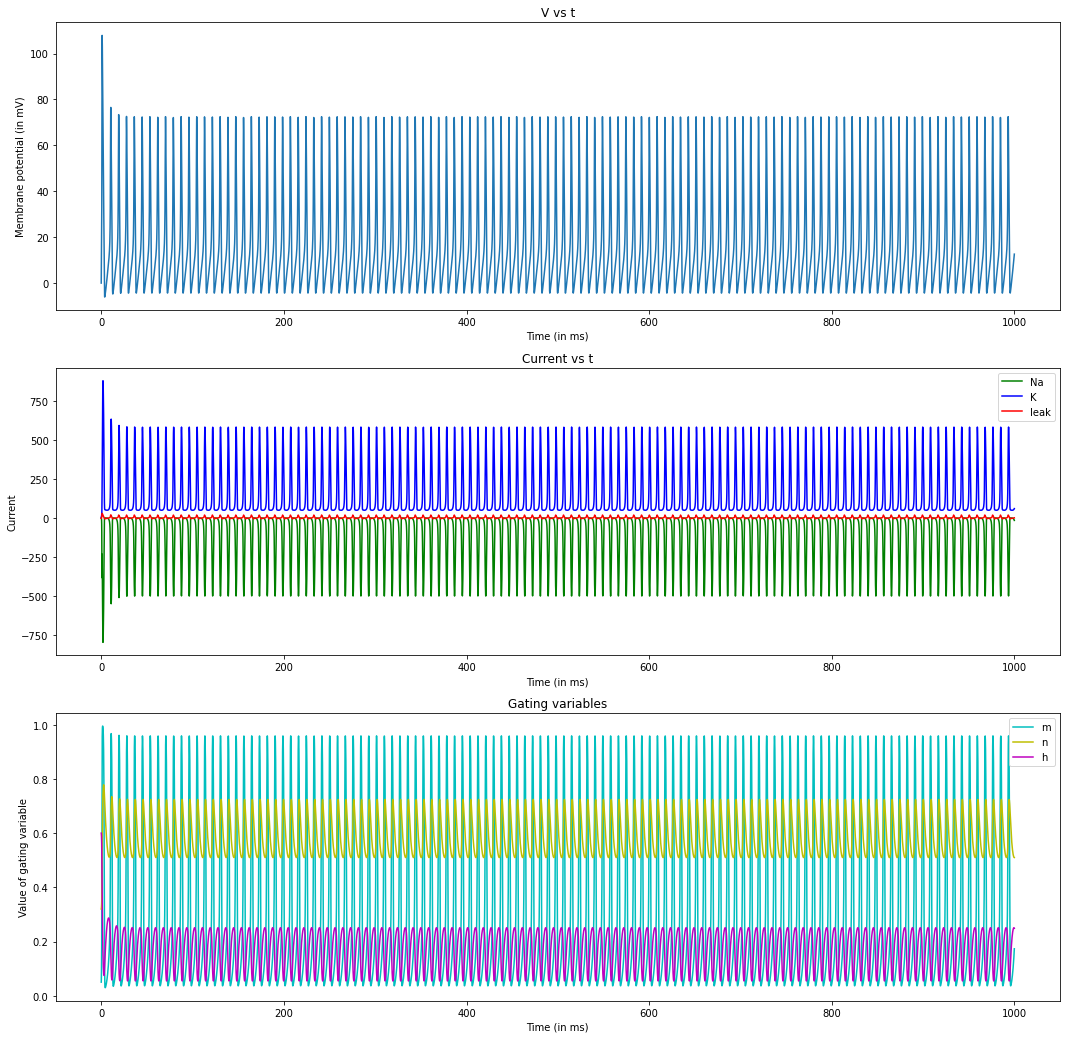

In [109]:
mymodel = Model()

#[V,m,h,n]
initial_vals = [0,0.05,0.6,0.32]


mymodel.run(initial_vals,I=50,t_start=0,t_end=1000,t_interval=0.1)

We can also examine how the behaviour changes as the injected current is varied.

In [111]:
def bifurcation(initial_vals,I_start=0, I_end = 20,I_interval=0.1):
   
    Ilist = np.arange(I_start,I_end,I_interval)
    
    V_list = []
    
    for I in Ilist:
        model = Model()
        V_vals = model.run(initial_vals,I,return_vals=True,plot=False)[0]
        stable_vals = np.unique(V_vals[len(V_vals)-100:len(V_vals)]) 
        V_list.append(stable_vals)
        
    x = []
    y = []
    for i in range(0,len(V_list)):
        for j in range(0,len(V_list[i])):
            x.append(Ilist[i])
            y.append(V_list[i][j])
    
    plt.figure(figsize=(8,8))
    plt.scatter(x,y,s=1)
    plt.xlabel("Current")
    plt.ylabel("Stable V values (mV)")
    plt.show()

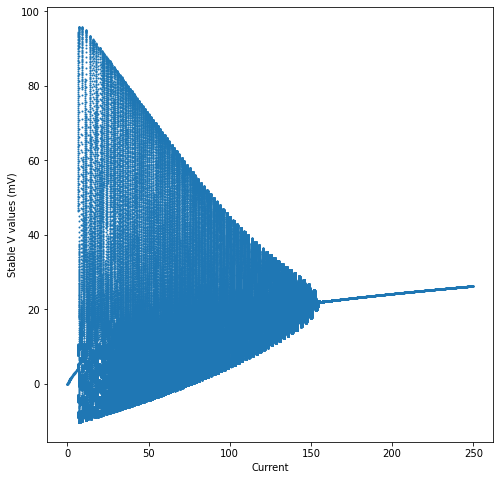

In [112]:
bifurcation(initial_vals,I_end=250,I_interval=0.1)

In [113]:
def max_volt(initial_vals,I_start=0, I_end = 20,I_interval=0.1):
    
    I_list = np.arange(I_start,I_end,I_interval)
    
    V_list = []
    
    for I in I_list:
        model = Model()
        V_vals = model.run(initial_vals,I,return_vals=True,plot=False)[0]
        max_val = np.max(V_vals[len(V_vals)-100:len(V_vals)]) 
        V_list.append(max_val)
        
    plt.figure(figsize=(8,8))
    plt.scatter(I_list,V_list,s=2)
    plt.xlabel("Current")
    plt.ylabel("Maximum V value (mV)")
    plt.show()

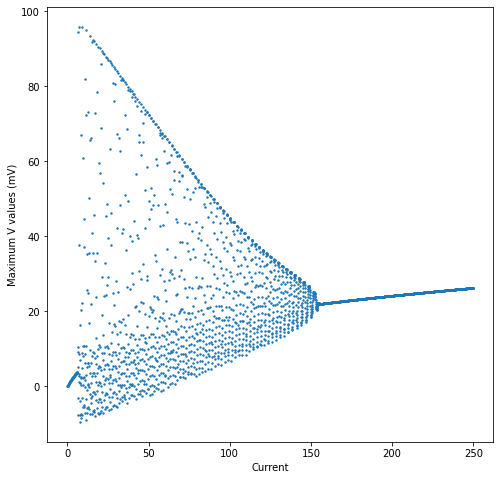

In [114]:
max_volt(initial_vals,I_end=250,I_interval=0.1)